In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.autonotebook import tqdm

from sklearn.model_selection import train_test_split

from glob import glob
import torch
import torch.nn as nn
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import torchvision

seed = 42

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Currently using "{device}" device.')

Currently using "cuda" device.


In [3]:
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

batch_size = 4
image_size = 256
num_classes = 1
epochs = 6
path = r'seg_model.pth'

In [6]:
import pandas as pd
from glob import glob

path_images = r'D:\Users\user\Desktop\CFD\train\CFD_img\\'
path_masks = r'D:\Users\user\Desktop\CFD\train\mask\\'

images_paths = glob(path_images + '*.png')
masks_paths = glob(path_masks + '*.png')

images_paths = sorted([str(p) for p in images_paths])
masks_paths = sorted([str(p) for p in masks_paths])

df = pd.DataFrame({'images': images_paths, 'masks': masks_paths})

# 使用sample方法随机选择两行进行查看
sample_df = df.sample(2)
print(sample_df)


                                               images  \
22  D:\Users\user\Desktop\CFD\train\CFD_img\CFD_04...   
0   D:\Users\user\Desktop\CFD\train\CFD_img\CFD_00...   

                                               masks  
22  D:\Users\user\Desktop\CFD\train\mask\CFD_041.png  
0   D:\Users\user\Desktop\CFD\train\mask\CFD_004.png  


In [14]:
train, test = train_test_split(df, test_size=10, shuffle=True, random_state=42)
train, valid = train_test_split(train, test_size=0.2, shuffle=True, random_state=42)

print(f'Train size: {len(train)}, validation size: {len(valid)} and test size: {len(test)}')

Train size: 48, validation size: 12 and test size: 10


In [15]:
train_transforms = T.Compose([
    T.ToPILImage(),
    T.Resize((image_size, image_size)),
    # add some color augmentations manually if needed
    T.ToTensor()
])

In [16]:
class CrackDataset(Dataset):
    def __init__(self, dataset, transforms=train_transforms):
        self.dataset = dataset.reset_index(drop=True)
        self.transforms = transforms
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, ix):
        row = self.dataset.loc[ix].squeeze()
        image_path = row['images']
        mask_path = row['masks']
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_tensor = self.transforms(image).float()
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = cv2.resize(mask, (image_size, image_size))
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        
        mask_tensor = torch.as_tensor(mask[None], dtype=torch.float32)
        
        # mask_tensor /= 255.
        
        return image_tensor, mask_tensor
    
    def collate_fn(self, batch):
        images, masks = tuple(zip(*batch))
        images = [img[None] for img in images]
        masks = [msk[None] for msk in masks]
        images, masks = [torch.cat(i).to(device) for i in [images, masks]]
        return images, masks

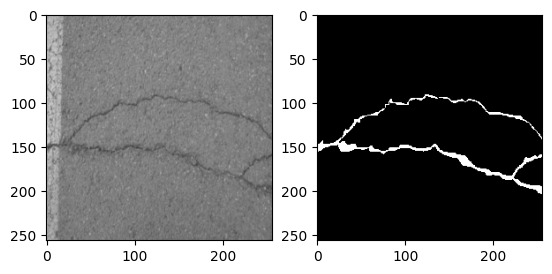

In [17]:
ds = CrackDataset(train)
plt.subplot(121)
plt.imshow(ds[1][0].cpu().detach().numpy().transpose(1,2,0))
plt.subplot(122)
plt.imshow(ds[1][1].cpu().detach().numpy().transpose(1,2,0), cmap='gray')

In [18]:
@torch.no_grad()
def validate_test_image(model, dataset):
    idx = np.random.randint(len(dataset))
    dataset = dataset.reset_index(drop=True)
    row = dataset.loc[idx].squeeze()
    
    image = cv2.imread(row['images'])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_tensor = train_transforms(image).unsqueeze(0).to(device)
    
    mask = cv2.imread(row['masks'])
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (image_size, image_size))
    _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    
    model.eval()
    output = model(image_tensor)
    output = output['out'][0].cpu().detach().numpy().transpose(1,2,0)
    
    plt.figure(figsize=(8, 4))
    plt.subplot(131)
    plt.title('Original image')
    plt.imshow(image)
    
    plt.subplot(132)
    plt.title('Original mask')
    plt.imshow(mask, cmap='gray')
    
    plt.subplot(133)
    plt.title('Predicted mask')
    plt.imshow(output, cmap='gray')
    
    plt.tight_layout()
    plt.show()
    plt.pause(0.001)

In [19]:
train_dataset = CrackDataset(train)
valid_dataset = CrackDataset(valid)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=valid_dataset.collate_fn, drop_last=True)

In [20]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

def get_model(output_channels=1, unfreeze=True):
    model = torchvision.models.segmentation.deeplabv3_resnet101(pretrained=True, progress=False)
    
    for param in model.parameters():
        param.requires_grad = unfreeze
    
    model.classifier = DeepLabHead(2048, output_channels)
    
    return model.to(device)

model = get_model()  # set output_channels = 3 if we work with colored masks

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\user/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth


In [21]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, path=path):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.early_stop = False
        
    def __call__(self, val_loss, model=None):
        if self.best_loss - val_loss > self.min_delta:
            torch.save(model.state_dict(), self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # if unfreeze=True -> 1e-4, 1e-5, so not to ruin good init w
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, min_lr=1e-6, factor=0.1)
early = EarlyStopping()

In [23]:
def train_one_batch(batch, model, criterion, optimizer):
    images, masks = batch
    optimizer.zero_grad()
    output = model(images)
    loss = criterion(output['out'], masks)
    loss.backward()
    optimizer.step()
    
    return loss.item()

@torch.no_grad()
def validate_one_batch(batch, model, criterion):
    images, masks = batch
    output = model(images)
    loss = criterion(output['out'], masks)
    return loss.item()

Epoch 1/6


Train loss: 870.8667.


Valid loss: 1047.0161.
--------------------------------------------------


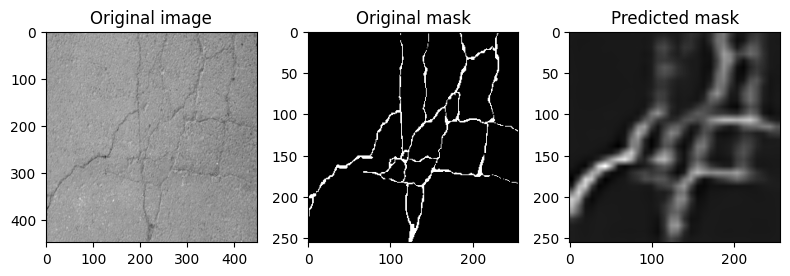

Model saved to: seg_model.pth
Epoch 2/6


Train loss: 865.2880.


Valid loss: 1025.1241.
--------------------------------------------------


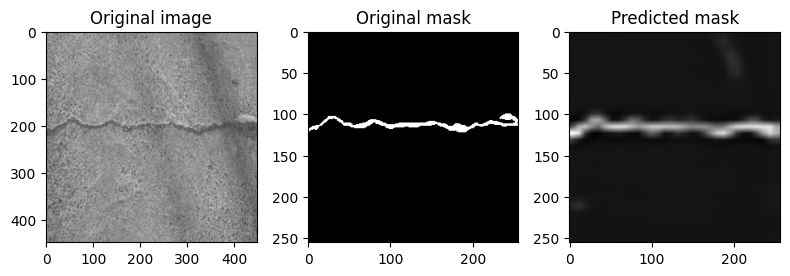

Model saved to: seg_model.pth
Epoch 3/6


Train loss: 859.6716.


Valid loss: 1024.9394.
--------------------------------------------------


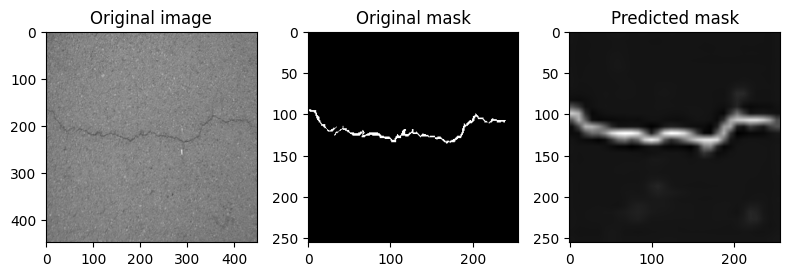

Model saved to: seg_model.pth
Epoch 4/6


Train loss: 854.9820.


Valid loss: 1020.8318.
--------------------------------------------------


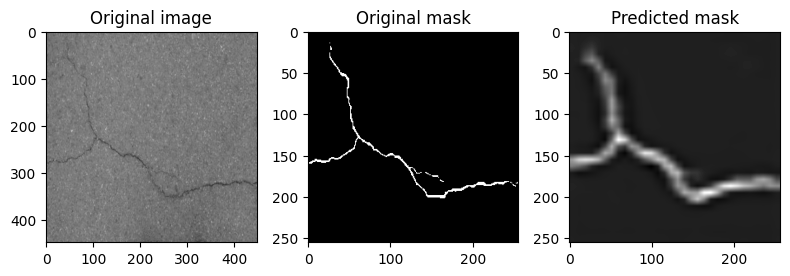

Model saved to: seg_model.pth
Epoch 5/6


Train loss: 850.1024.


Valid loss: 1017.1549.
--------------------------------------------------


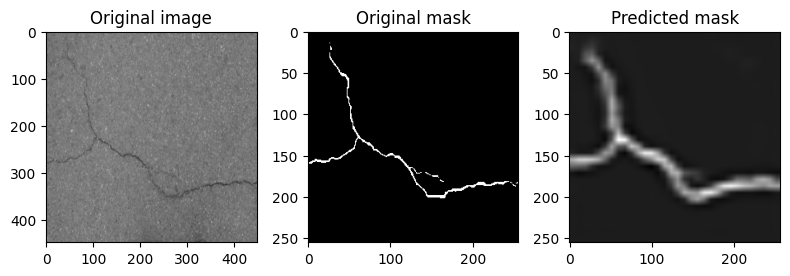

Model saved to: seg_model.pth
Epoch 6/6


Train loss: 845.2914.


Valid loss: 1017.0476.
--------------------------------------------------


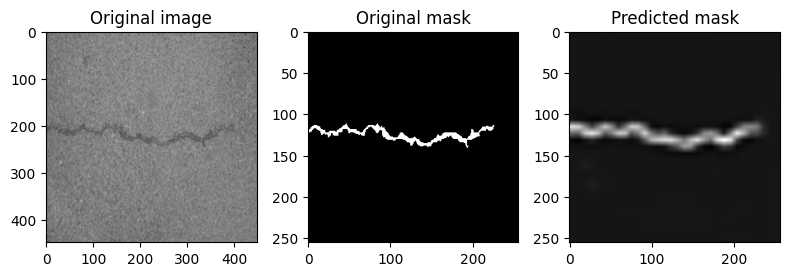

Model saved to: seg_model.pth


In [29]:
train_losses, valid_losses = [], []

for epoch in range(epochs):

    print(f'Epoch {epoch + 1}/{epochs}')
    epoch_train_losses, epoch_valid_losses = [], []
    
    model.train()
    for _, batch in enumerate(tqdm(train_dataloader, leave=False)):
        batch_train_loss = train_one_batch(batch, model, criterion, optimizer)
        epoch_train_losses.append(batch_train_loss)
    epoch_train_loss = np.array(epoch_train_losses).mean()
    train_losses.append(epoch_train_loss)
    print(f'Train loss: {epoch_train_loss:.4f}.')
    
    model.eval()
    for i, batch in enumerate(tqdm(valid_dataloader, leave=False)):
        batch_valid_loss = validate_one_batch(batch, model, criterion)
        epoch_valid_losses.append(batch_valid_loss)
    epoch_valid_loss = np.array(epoch_valid_losses).mean()
    valid_losses.append(epoch_valid_loss)
    print(f'Valid loss: {epoch_valid_loss:.4f}.')
    print('-'*50)    
    
    validate_test_image(model, test)
    
    scheduler.step(epoch_valid_loss)
    early(epoch_valid_loss, model=model)
    if early.early_stop:
        print(f'Validation loss did not improve for {early.patience} epochs. Training stopped.')
        model.load_state_dict(torch.load(path))
        break

In [39]:
test_dataset = CrackDataset(test)


test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn, drop_last=True)

# 定义变量来保存测试集的预测值和真实标签
test_data = []  # 存储测试数据的列表
test_labels = []  # 存储测试标签的列表
for image, label in test_dataset:
    test_data.append(image)
    test_labels.append(label.item())  # 使用 .item() 获取标签的值


# 创建测试数据加载器
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_predictions = []
test_true_labels = []


model.eval()  # 设置模型为评估模式

for i, batch in enumerate(tqdm(test_dataloader, leave=False)):
    # 获取模型的预测值
    batch_inputs, batch_labels = batch
    with torch.no_grad():
        batch_predictions = model(batch_inputs)

    # 将预测值和真实标签添加到相应的列表中
    test_predictions.extend(batch_predictions)
    test_true_labels.extend(batch_labels)

# 将预测值和真实标签转换为二进制的类别（0或1）
predicted_labels_test = [1 if p.item() > 0.5 else 0 for p in test_predictions]
true_labels_test = [t.item() for t in test_true_labels]

# 计算混淆矩阵
confusion_matrix_result_test = confusion_matrix(true_labels_test, predicted_labels_test)

# 打印测试集的混淆矩阵
print("Test Set Confusion Matrix:")
print(confusion_matrix_result_test)


RuntimeError: a Tensor with 65536 elements cannot be converted to Scalar

In [26]:
torch.save(model,"seg_model.pth")

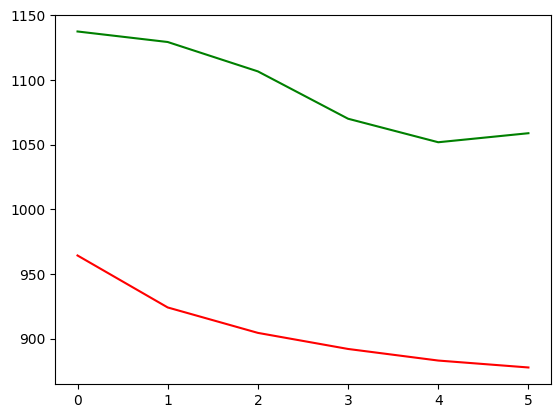

In [27]:
import matplotlib.pyplot as plt
plt.plot(train_losses,c="red")
plt.plot(valid_losses,c="green")
plt.show()

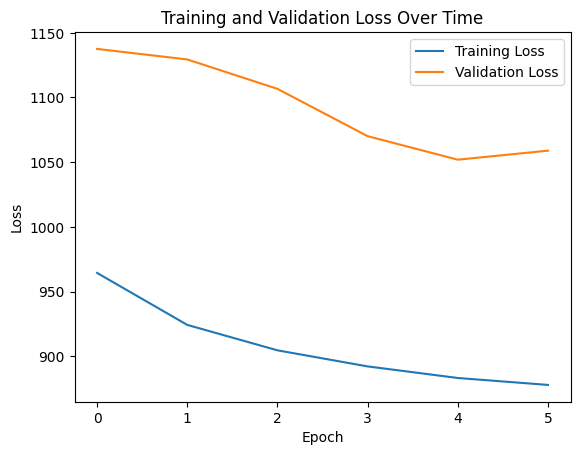

In [28]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model,"/kaggle/working/model.pt")